<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/warfare/blob/main/PS_IL_%22Conflict%22_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/content/drive/MyDrive/warfare/2023-10-01-2024-08-28-Middle_East-Israel-Palestine.csv")

In [3]:
## CHECK DUPLICATE EVENT IDs HAVE SAME FATALITY REPORTS
df = df.drop_duplicates(subset=['event_id_cnty'], keep='last')

In [4]:
# Convert event string to datetime
df['event_date'] = pd.to_datetime(df['event_date'])

# Sort those values in time
df.sort_values(by='event_date', inplace=True)

##Daily Fatalities

In [5]:
# Sum total fatalities per day in each country
daily_df = df[['event_date','fatalities','country']].groupby(['event_date','country']).sum().reset_index()

In [6]:
# Pivot data to have column-wise fatalities per country (for plotting)
daily_df_pivot = daily_df.pivot(index='event_date', columns='country', values='fatalities')

In [7]:
# Fill any missing dates with zero deaths

# Determine the date range
start_date = daily_df_pivot.index.min()
end_date = daily_df_pivot.index.max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex and fill any missing values with zero
daily_df_pivot = daily_df_pivot.reindex(date_range).fillna(0)

In [8]:
daily_df_pivot['7-day average'] = daily_df_pivot.rolling(7).mean().sum(axis=1)

Text(0.5, 1.0, 'Daily reported fatalities Israel-Palestine conflict')

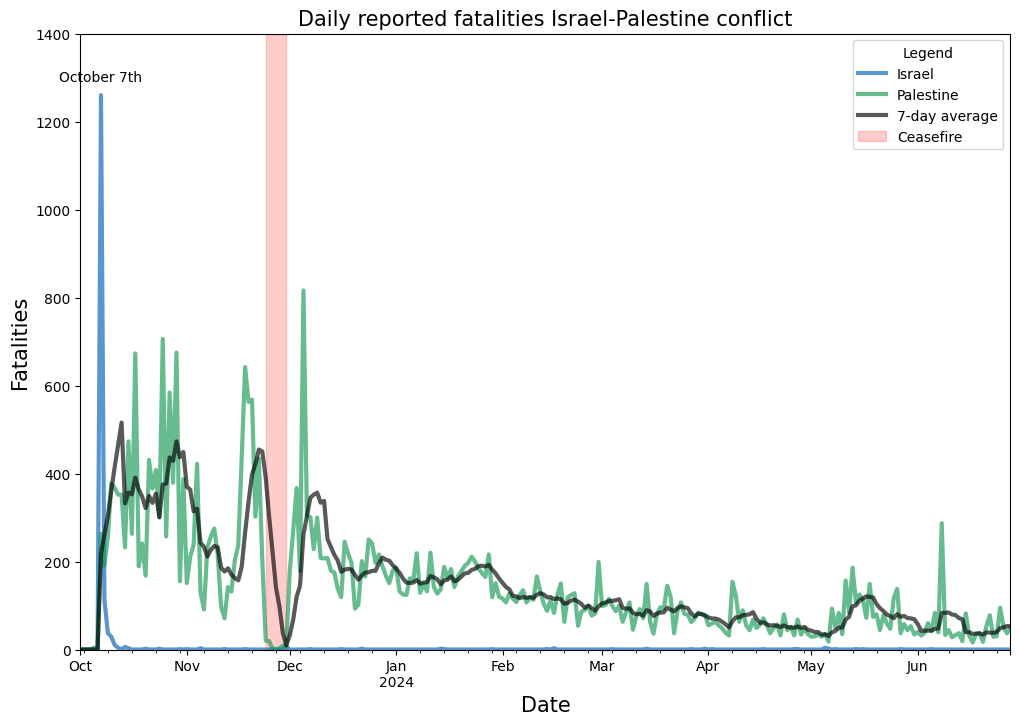

In [9]:
# Plot the result
ceasefire_start = "2023-11-24"
ceasefire_end = "2023-11-30"

fig, ax = plt.subplots(figsize = (12,8))
daily_df_pivot.plot(kind='line', color=['#005EB8','#149954','#000000'], ax=ax, alpha=0.65, lw=3)
ax.axvspan(ceasefire_start, ceasefire_end, color='red', alpha=0.2, label='Ceasefire')

# Annotate October 7th
x_coord = daily_df_pivot.idxmax()['Israel']
y_coord = daily_df_pivot.max()['Israel']
label = 'October 7th'
plt.annotate(label, (x_coord, y_coord), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Date', fontsize = 15)
plt.ylabel('Fatalities', fontsize = 15)
plt.legend(title='Legend')
plt.ylim(0,1400)
plt.title('Daily reported fatalities Israel-Palestine conflict', fontsize = 15)

##Cumulative fatalities

In [10]:
# Sum daily events in per country
df_grouped = df.groupby(['event_date', 'country']).sum().reset_index()

# Cumulative summation of fatalities across countries
df_grouped['cumulative_fatalities'] = df_grouped[['country', 'fatalities']].groupby(['country']).cumsum()

# Pivot data to have column-wise fatalities per country (for plotting)
pivot_df_cumsum = df_grouped.pivot(index='event_date', columns='country', values='cumulative_fatalities')

In [11]:
# Fill any missing dates

# Determine the date range
start_date = pivot_df_cumsum.index.min()
end_date = pivot_df_cumsum.index.max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex and fill any missing values with previous day
pivot_df_cumsum = pivot_df_cumsum.reindex(date_range).fillna(method='ffill')

<ipython-input-11-30c83c697ff2>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot_df_cumsum = pivot_df_cumsum.reindex(date_range).fillna(method='ffill')


Text(0.5, 1.0, 'Cumulative reported fatalities')

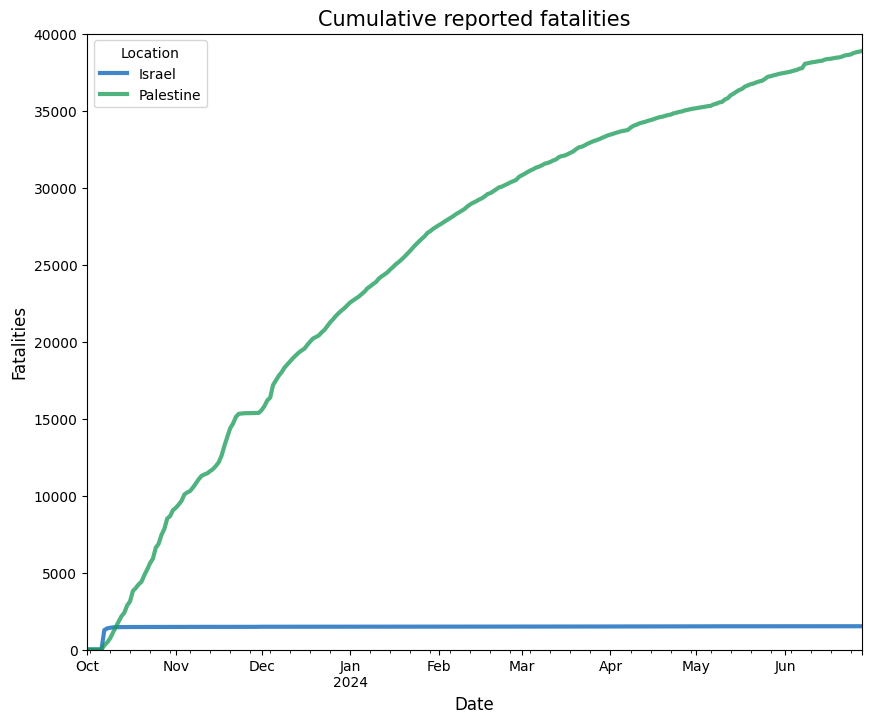

In [12]:
# Create a line plot
fig, ax = plt.subplots(figsize = (10,8))
pivot_df_cumsum.plot(kind='line', color=['#005EB8','#149954'], alpha=0.75, lw = 3, ax=ax)
plt.legend(title='Location')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Fatalities', fontsize=12)
plt.ylim(0,40000)
plt.title('Cumulative reported fatalities', fontsize=15)

##Types of events

Text(0, 0.5, 'Number of individual reported events')

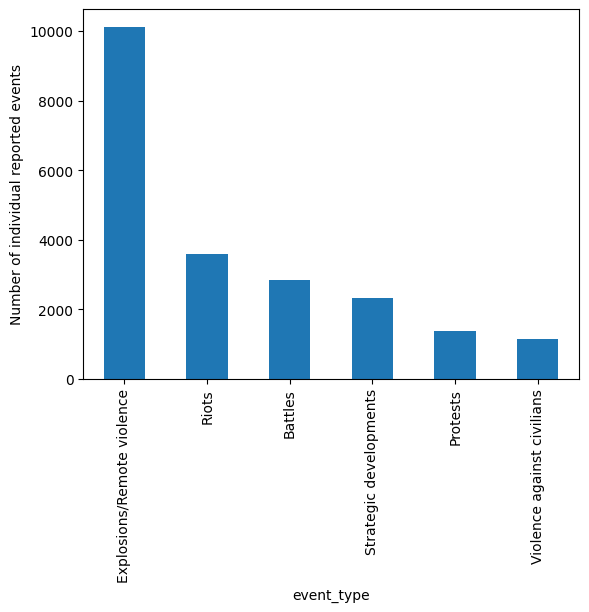

In [13]:
df.event_type.value_counts().plot.bar()
plt.ylabel('Number of individual reported events')

<Axes: xlabel='disorder_type'>

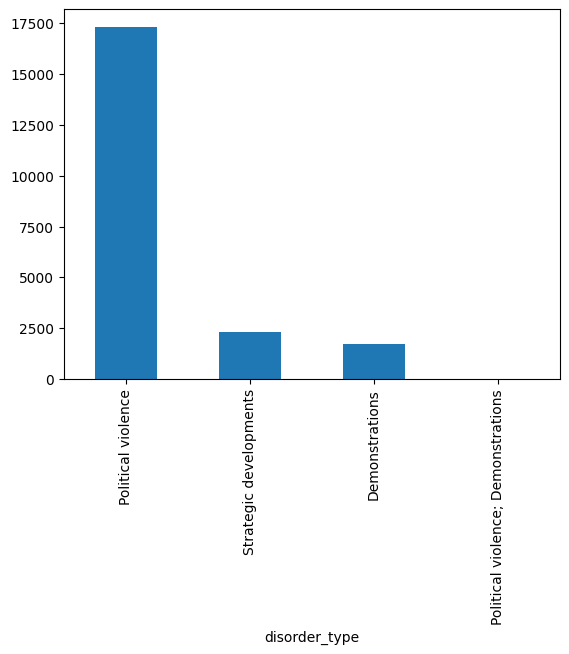

In [14]:
df.disorder_type.value_counts().plot.bar()

##Map-wise visualisation (in-development)

In [15]:
df_deaths = df[df['fatalities'] > 0]
df_deaths_gp = df[['longitude', 'latitude','fatalities']].groupby(['longitude', 'latitude']).sum().reset_index()

In [16]:
unique_loc = df[['longitude', 'latitude','country']].drop_duplicates()

In [17]:
import folium
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Create a base map centered around Israel/Palestine
m = folium.Map(location=[31.5, 34.5], tiles="CartoDB Positron", zoom_start=9)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_deaths_gp, geometry=gpd.points_from_xy(df_deaths_gp.longitude, df_deaths_gp.latitude))

# Function to add points to the folium map
def add_points_to_map(gdf, map_obj):
    for _, row in gdf.iterrows():

        country = unique_loc[(unique_loc['latitude'] == row['latitude']) & (unique_loc['longitude'] == row['longitude'])]['country'].values[0]
        if country == 'Palestine':
            colour_in = 'red'
        else:
            colour_in = 'blue'

        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=row['fatalities'] / 10,  # Adjust the size as needed
            color=colour_in,
            fill=True,
            fill_color=colour_in
        ).add_to(map_obj)

# Add points to the map
add_points_to_map(gdf, m)

In [18]:
m

##Visualsing protests

In [19]:
df_protests = df[df['event_type'] == 'Protests']

In [20]:
# Convert tag to numbers
text_to_num = {
    'no report': float('nan'),
    'hundreds': 200,
    'thousands': 2000,
    'dozens': 36,
    'about 20 to 100': 60,
    'over 100': 120,
    'a few dozen': 36,
    '200':200,
    'tens': 30,
    'several hundred': 400,
    'large': 50,
    'dozens to hundreds':200,
    'about 200':200,
    'about 1,000':1000,
    'dozens to about 100':84,
    'tens of thousands':30000,
    'about 400': 400,
    'about 100,000': 100000,
    'about 300': 300,
    'about 150': 150,
    'about 20': 20,
    'about 250': 250,
    'at least 200': 200,
    'about 50': 50,
    'about 2,000': 2000,
    'about 20,000': 20000,
    'about 40': 40,
    'about 100': 100,
    'about 30': 30,
    'around 10,000': 10000,
    'at least 1,000': 1100,
    'about 120,000': 120000,
    'several dozen': 60,
    'at least 2,000': 2000,
    'about 200 to 300': 250,
    'about 5,000': 5000
}

# Function to convert text to number
def convert_to_number(text):
    for key in text_to_num:
        if key in text:
            return text_to_num[key]
    return None


df_protests['crowd_size'] = df_protests['tags'].apply(convert_to_number)

<ipython-input-20-48b36fd00281>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protests['crowd_size'] = df_protests['tags'].apply(convert_to_number)


In [21]:
daily_protests = df_protests[['event_date','crowd_size','country']].groupby(['event_date','country']).sum().reset_index()

In [22]:
daily_protests_pivot = daily_protests.pivot(index='event_date', columns='country', values='crowd_size')

In [23]:
# Fill any missing dates with zero deaths

# Determine the date range
start_date = daily_protests_pivot.index.min()
end_date = daily_protests_pivot.index.max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex and fill any missing values with zero
daily_protests_pivot = daily_protests_pivot.reindex(date_range).fillna(0)

In [24]:
daily_protests.max()

,0
event_date,2024-06-28 00:00:00
country,Palestine
crowd_size,128650.0


Text(0, 0.5, 'Approximate attendees')

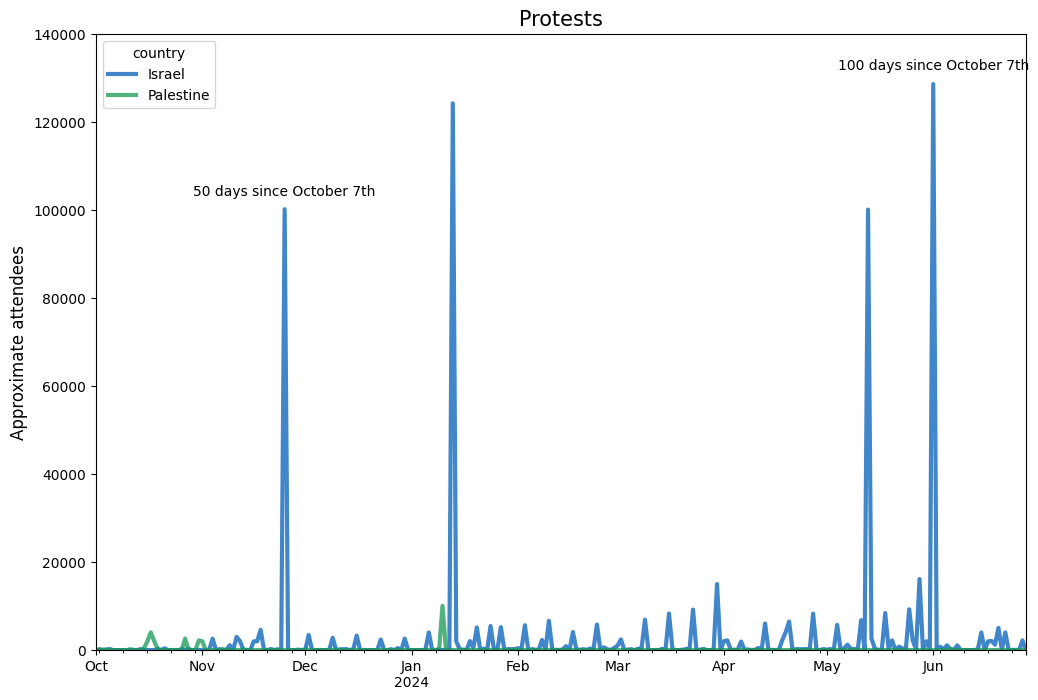

In [25]:
fig, ax = plt.subplots(figsize = (12,8))
daily_protests_pivot.plot(color=['#005EB8','#149954'], alpha=0.75, ax=ax, lw=3)


# Global day of action for Palestine
x_coord = daily_protests_pivot.idxmax()['Israel']
y_coord = daily_protests_pivot.max()['Israel']
label = '100 days since October 7th'
plt.annotate(label, (x_coord, y_coord), textcoords="offset points", xytext=(0,10), ha='center')

# Global day of action for Palestine
x_coord = '2023-11-25 00:00:00'
y_coord = 100000
label = '50 days since October 7th'
plt.annotate(label, (x_coord, y_coord), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Protests', fontsize=15)
plt.ylim([0,140000])
plt.ylabel('Approximate attendees', fontsize=12)

##Experimental modelling

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score# Split the data into training and testing sets

In [27]:
pivot_df_cumsum.sort_index(inplace=True)
pivot_df_cumsum

country,Israel,Palestine
2023-10-01,0.0,0.0
2023-10-02,0.0,0.0
2023-10-03,0.0,0.0
2023-10-04,0.0,0.0
2023-10-05,0.0,4.0
...,...,...
2024-06-24,1512.0,38640.0
2024-06-25,1512.0,38735.0
2024-06-26,1512.0,38786.0
2024-06-27,1512.0,38823.0


In [28]:
# Skip to first deaths in the dataset
pivot_df_cumsum = pivot_df_cumsum[4:]

In [29]:
pivot_df_cumsum.reset_index().index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [30]:
X = pivot_df_cumsum.reset_index().index.values.reshape(-1,1)
y = pivot_df_cumsum.reset_index()['Palestine']

Polynomial regression

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [33]:
# Fit a polynomial regression model
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

# Predict on the test set
y_pred = poly_reg.predict(X_test_poly)

Mean Squared Error: 489920.39
R-squared: 1.00


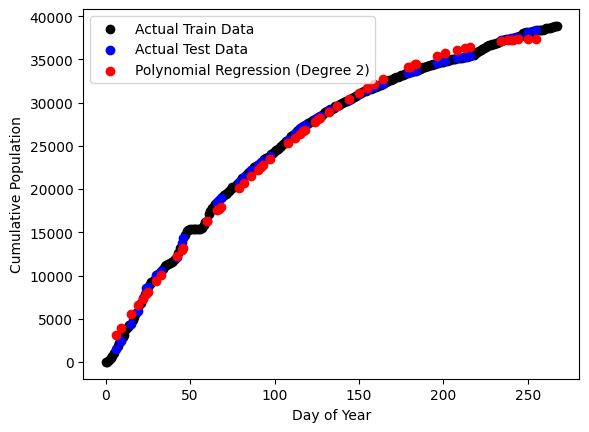

In [34]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Plot the original data and the polynomial regression line
plt.scatter(X_train, y_train, color='black', label='Actual Train Data')  # Plot the test data
plt.scatter(X_test, y_test, color='blue', label='Actual Test Data')  # Plot the test data
plt.scatter(X_test, y_pred, color='red', label='Polynomial Regression (Degree 2)')
plt.xlabel('Day of Year')
plt.ylabel('Cumulative Population')
plt.legend()
plt.show()

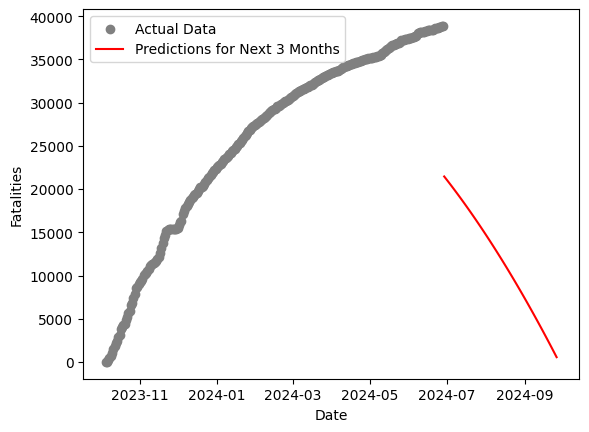

In [37]:
# Extend the index to include the next 3 months
last_date = pivot_df_cumsum.index.max()
next_3_months = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90, freq='D')

# Last index of previous data
last_index = pivot_df_cumsum.reset_index().index.values[-1] - 20 # Where does this 20 come in?

# Create corresponding day-of-year values for the next 3 months
next_3_months_dayofyear = next_3_months.to_series().dt.dayofyear.values.reshape(-1, 1) + last_index

# Use the polynomial regression model to make predictions for the next 3 months
predictions = poly_reg.predict(poly.transform(next_3_months_dayofyear))

# Plot the original data, the polynomial regression line, and the predictions for the next 3 months
plt.scatter(pivot_df_cumsum.index, y, color='grey', label='Actual Data')
#plt.plot(pivot_df_filled.index, poly_reg.predict(X_train_poly), color='red', label='Polynomial Regression (Degree 2)')
plt.plot(next_3_months, predictions, color='red', label='Predictions for Next 3 Months')
plt.xlabel('Date')
plt.ylabel('Fatalities')
plt.legend()
plt.show()

Logistic growth model

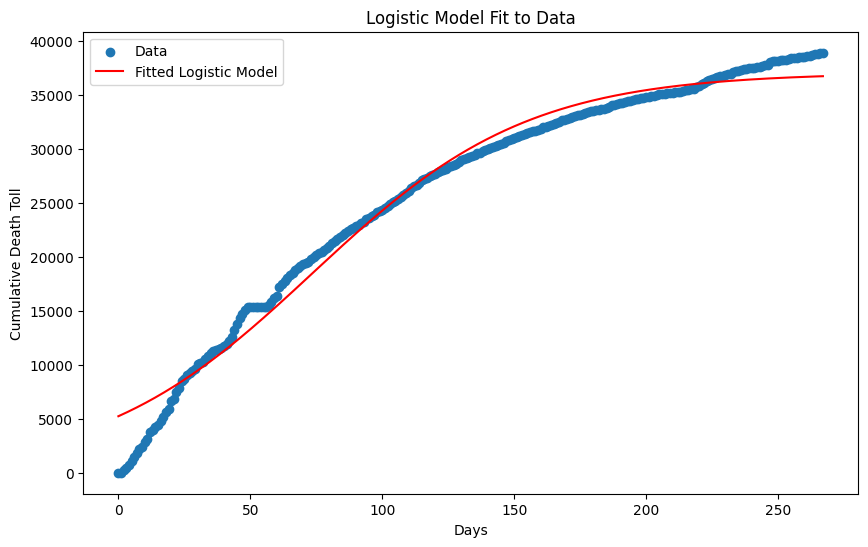

In [38]:
from scipy.optimize import curve_fit
import numpy as np

def logistic_model(x, c, k, t0):
    return c / (1 + np.exp(-k * (x - t0)))

# Prepare the data for fitting
x_data = pivot_df_cumsum.reset_index().index.values
y_data = pivot_df_cumsum['Palestine']

# Initial guess for the parameters
initial_guess = [max(y_data), 1, np.median(x_data)]

# Use curve_fit to fit the model
params, covariance = curve_fit(logistic_model, x_data, y_data, p0=initial_guess)

# Extract the parameters
c, k, t0 = params

# Generate a sequence of x values
x_model = np.linspace(x_data.min(), x_data.max(), 1000)

# Apply the logistic model
y_model = logistic_model(x_model, c, k, t0)

# Plot the data and the model prediction
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_model, y_model, label='Fitted Logistic Model', color='red')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Cumulative Death Toll')
plt.title('Logistic Model Fit to Data')
plt.show()

In [39]:
# Differencing the series
diff = pivot_df_cumsum.diff(periods=1).dropna()

In [40]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

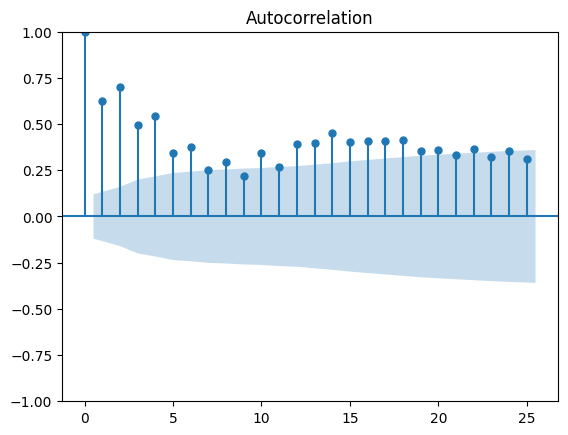

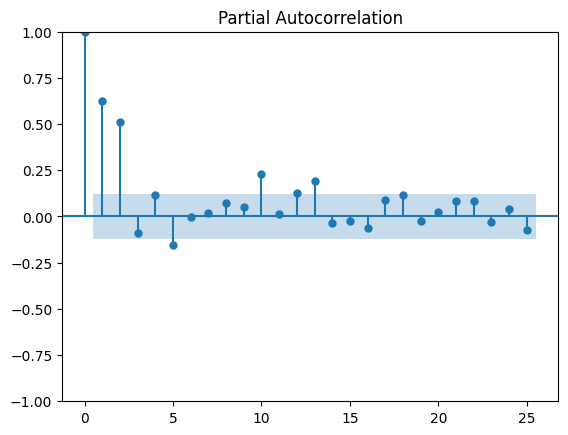

In [41]:
plot_acf(diff['Palestine'])
plot_pacf(diff['Palestine'])
plt.show()

ARIMA

In [42]:
# ARIMA Model
model = ARIMA(diff['Palestine'], order=(1, 1, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Palestine   No. Observations:                  267
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1573.765
Date:                Sat, 17 Aug 2024   AIC                           3153.529
Time:                        01:45:35   BIC                           3164.279
Sample:                    10-06-2023   HQIC                          3157.848
                         - 06-28-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6878      0.051    -13.409      0.000      -0.788      -0.587
ma.L1          0.1342      0.085      1.588      0.112      -0.031       0.300
sigma2      8047.7525    327.588     24.567      0.0

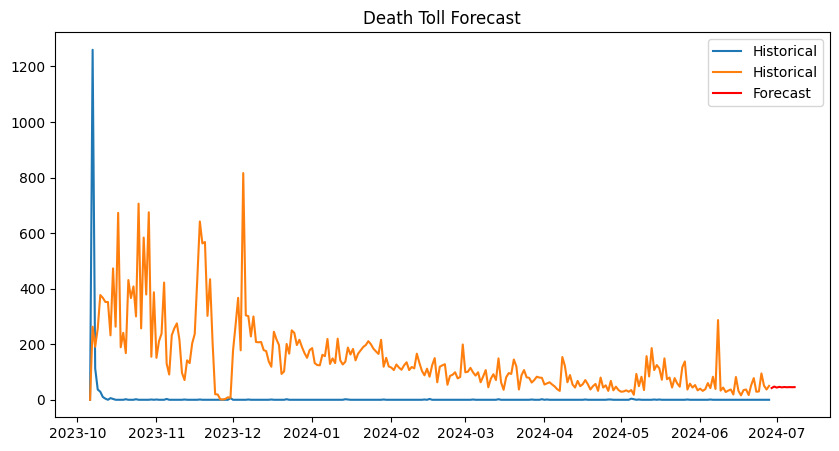

In [43]:
forecast_periods = 10
last_date = diff.index[-1]

forecast_index = pd.date_range(start=last_date, periods=forecast_periods + 1, freq='D')[1:]

forecast = model_fit.forecast(steps=forecast_periods)

forecast_df = pd.DataFrame(forecast.values, index=forecast_index, columns=['Forecast'])

plt.figure(figsize=(10,5))
plt.plot(diff, label='Historical')
plt.plot(forecast_df, label='Forecast', color='red')
plt.title('Death Toll Forecast')
plt.legend()
plt.show()